In [1]:
%matplotlib inline
!CUDA_LAUNCH_BLOCKING=1
!CUDA_DEVICE_ORDER="PCI_BUS_ID"
!CUDA_VISIBLE_DEVICES='0'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from tensorflow.keras.layers import Input, ZeroPadding2D,concatenate, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, UpSampling2D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
# import efficientnet.keras as efn
import h5py, glob
import pickle5 as pickle
import numpy as np
import itertools
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(1)

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

W1024 21:19:44.268220 140286204227712 deprecation.py:323] From <ipython-input-2-ebb74ce83619>:3: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
### CAE hyp
batch_size = 32
epochs = 500
inChannel = 3
x, y = 224, 224 # height, width
input_img = Input(shape = (x, y, inChannel))
num_class = 10

# Load Data

In [4]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [5]:
[train_images, train_labels, train_files,
 test_images, test_labels, test_files] = load_pkl('../datasets/imit_ASL_10_mDreal_224x224.pkl')
train_images = np.swapaxes(np.swapaxes(train_images, 1, 3), 1, 2)
test_images = np.swapaxes(np.swapaxes(test_images, 1, 3), 1, 2)
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1539, 224, 224, 3)
(1539,)
(385, 224, 224, 3)
(385,)


In [6]:
[train_images2, train_labels2, train_files2,
 test_images2, test_labels2, test_files2] = load_pkl('../datasets/imit_ASL_10_mDsim_224x224.pkl')
train_images2 = np.swapaxes(np.swapaxes(train_images2, 1, 3), 1, 2)
test_images2 =np.swapaxes( np.swapaxes(test_images2, 1, 3), 1, 2)
train_labels2 = np.argmax(train_labels2, -1)
test_labels2 = np.argmax(test_labels2, -1)

print(train_images2.shape)
print(train_labels2.shape)
print(test_images2.shape)
print(test_labels2.shape)

(1539, 224, 224, 3)
(1539,)
(385, 224, 224, 3)
(385,)


In [7]:
def plot_fig(i, history):
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['accuracy'],label='Training')
    plt.plot(range(1,epochs+1),history.history['val_accuracy'],label='Validation')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
#     fig.savefig('results/Model'+str(i)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'-acc.png')
    plt.close(fig)
    # summarize history for loss
    fig2 = plt.figure()
    plt.plot(range(1,epochs+1),history.history['loss'],label='Training')
    plt.plot(range(1,epochs+1),history.history['val_loss'],label='Validation')
    plt.legend(loc=0)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
#     fig2.savefig('results/Model'+str(i)+'_'+str(radar)+'GHz'+'_Batchsize'+str(BATCH_SIZE)+'_learning'+str(lr)+'_dropout'+str(drop)+'-loss.png')
    plt.close(fig2)

## Encoder and Decoder

In [49]:
def encoder(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv01 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='same')(input_img) # 128x128x8
    conv02 = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
    out01  = concatenate([conv01,conv02],axis=-1)
    pool01 = MaxPooling2D(pool_size=(2, 2))(out01) #14 x 14 x 32, 64x64x8
    
    conv1 = Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool01) # 128x128x8
    conv2 = Conv2D(128, (9, 9), activation='relu', padding='same')(pool01)
    out1  = concatenate([conv1,conv2],axis=-1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32, 64x64x8
    
#     conv3 = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool1) # 64x64x16
# #     conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool1)
# #     out2  = concatenate([conv3,conv4],axis=-1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv3) # 16x16x16
    
#     conv5 = Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same')(pool2) # 64x64x16
# #     conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool2)
# #     out2  = concatenate([conv5,conv4],axis=-1)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv5) # 16x16x16
    
    return pool1

def decoder(pool2):    
    #decoder
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) # 16x16x16
    conv10 = Conv2D(128, (9, 9), activation='relu', padding='same')(pool2)
    out5  = concatenate([conv9,conv10], axis=-1)
    up2   = UpSampling2D((2,2))(out5) # 64x64x16
    
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2) # 64x64x8
    conv12 = Conv2D(64, (9, 9), activation='relu', padding='same')(up2)
    out6  = concatenate([conv11,conv12], axis=-1)
    up3 = UpSampling2D((2,2))(out6) #  128x128x8
#     zero = ZeroPadding2D(padding=(1, 1), data_format=None)(up3)
    
#     conv17 = Conv2D(16, (3, 3), activation='relu', padding='same')(up3) # 64x64x8
# #     conv18 = Conv2D(32, (9, 9), activation='relu', padding='same')(up3)
# #     out7  = concatenate([conv17,conv18], axis=-1)
#     up4 = UpSampling2D((2,2))(conv17) #  128x128x8
    
#     conv19 = Conv2D(16, (3, 3), activation='relu', padding='same')(up4) # 64x64x8
# #     conv20 = Conv2D(8, (9, 9), activation='relu', padding='same')(up4)
# #     out7  = concatenate([conv19,conv20], axis=-1)
#     up5 = UpSampling2D((2,2))(conv19) #  128x128x8
    
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(up3) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    
    return decoded

def encoder77(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv01 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
    conv02 = Conv2D(8, (9, 9), activation='relu', padding='same')(input_img)
    conv03 = Conv2D(8, (5, 5), activation='relu', padding='same')(input_img)
    
    out01  = concatenate([conv01,conv02,conv03],axis=-1)
    pool01 = MaxPooling2D(pool_size=(4, 4))(out01) #14 x 14 x 32, 64x64x8
    
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool01) # 128x128x8
    conv2 = Conv2D(8, (9, 9), activation='relu', padding='same')(pool01)
    conv21 = Conv2D(8, (5, 5), activation='relu', padding='same')(pool01)
    out1  = concatenate([conv1,conv2,conv21],axis=-1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(out1) #14 x 14 x 32, 64x64x8
    
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
    conv4 = Conv2D(8, (9, 9), activation='relu', padding='same')(pool1)
    conv41 = Conv2D(8, (5, 5), activation='relu', padding='same')(pool1)
    out2  = concatenate([conv3,conv4,conv41],axis=-1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(out2) # 16x16x16

    return pool2

def decoder77(pool3):    
    #decoder
    conv9 = Conv2D(8, (9, 9), activation='relu', padding='same')(pool3) # 16x16x16
    conv10 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool3)
    conv101 = Conv2D(8, (5, 5), activation='relu', padding='same')(pool3)
    out5  = concatenate([conv9,conv10,conv101], axis=-1)
    up2   = UpSampling2D((2,2))(out5) # 64x64x16
    
    conv11 = Conv2D(8, (9, 9), activation='relu', padding='same')(up2) # 64x64x8
    conv12 = Conv2D(8, (3, 3), activation='relu', padding='same')(up2)
    conv121 = Conv2D(8, (5, 5), activation='relu', padding='same')(up2)
    out6  = concatenate([conv11,conv12,conv121], axis=-1)
    up3 = UpSampling2D((2,2))(out6) #  128x128x8
    
    conv17 = Conv2D(8, (9, 9), activation='relu', padding='same')(up3) # 64x64x8
    conv18 = Conv2D(8, (3, 3), activation='relu', padding='same')(up3)
    conv181 = Conv2D(8, (5, 5), activation='relu', padding='same')(up3)
    out7  = concatenate([conv17,conv18,conv181], axis=-1)
    up5 = UpSampling2D((4,4))(out7) #  128x128x8
    
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up5) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    return decoded
def encoderMNIST(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv01 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
#     conv02 = Conv2D(32, (9, 9), activation='relu', padding='same')(input_img)
#     out01  = concatenate([conv01,conv02],axis=-1)
    pool01 = MaxPooling2D(pool_size=(2, 2))(conv01) #14 x 14 x 32, 64x64x8
    
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool01) # 128x128x8
#     conv2 = Conv2D(32, (1, 1), activation='relu', padding='same')(pool01)
#     out1  = concatenate([conv1,conv2],axis=-1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(out1) #14 x 14 x 32, 64x64x8
    
#     conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
#     conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool1)
#     out2  = concatenate([conv3,conv4],axis=-1)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(out2) # 16x16x16
    
    return pool01

def decoderMNIST(pool2):    
    #decoder
#     conv9 = Conv2D(32, (1, 1), activation='relu', padding='same')(pool2) # 16x16x16
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
#     out5  = concatenate([conv9,conv10], axis=-1)
    up2   = UpSampling2D((2,2))(conv10) # 64x64x16
    
#     conv11 = Conv2D(32, (9, 9), activation='relu', padding='same')(up2) # 64x64x8
#     conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
#     out6  = concatenate([conv11,conv12], axis=-1)
#     up3 = UpSampling2D((2,2))(out6) #  128x128x8
    
#     conv17 = Conv2D(32, (9, 9), activation='relu', padding='same')(up3) # 64x64x8
#     conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
#     out7  = concatenate([conv17,conv18], axis=-1)
#     up5 = UpSampling2D((2,2))(out7) #  128x128x8
    
    decoded = Conv2D(1, (3, 3), activation='relu', padding='same')(up2) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    
    return decoded
def encoder6(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
    conv2 = Conv2D(16, (9, 9), activation='relu', padding='same')(input_img)
    out1  = concatenate([conv1,conv2],axis=-1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(out1) #14 x 14 x 32, 64x64x8
    
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
    conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool1)
    out2  = concatenate([conv3,conv4],axis=-1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(out2) # 16x16x16
    
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) # 16x16x32 
    conv6 = Conv2D(64, (5, 5), activation='relu', padding='same')(pool2)
    out3  = concatenate([conv5,conv6],axis=-1)
    pool3 = MaxPooling2D(pool_size=(2, 2))(out3) # 4x4x32  (small and thick)
    
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3) # 16x16x32 
    conv8 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool3)
    out4  = concatenate([conv7,conv8],axis=-1)
    pool4 = MaxPooling2D(pool_size=(2, 2))(out4) # 4x4x32  (small and thick)
    
    return pool4

def decoder6(pool4):    
    #decoder
    conv13 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool4) # 4x4x32
    conv14 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    out7  = concatenate([conv13,conv14], axis=-1)
    up4   = UpSampling2D((2,2))(out7) #  16x16x32
    
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same')(up4) # 4x4x32
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
    out4  = concatenate([conv7,conv8], axis=-1)
    up1   = UpSampling2D((2,2))(out4) #  16x16x32
    
    conv9 = Conv2D(32, (9, 9), activation='relu', padding='same')(up1) # 16x16x16
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    out5  = concatenate([conv9,conv10], axis=-1)
    up2   = UpSampling2D((2,2))(out5) # 64x64x16
    
    conv11 = Conv2D(16, (9, 9), activation='relu', padding='same')(up2) # 64x64x8
    conv12 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    out6  = concatenate([conv11,conv12], axis=-1)
    up3 = UpSampling2D((4,4))(out6) #  128x128x8
    
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    return decoded

def encoderTobb(input_img):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    conv01 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) # 128x128x8
    conv02 = Conv2D(32, (9, 9), activation='relu', padding='same')(input_img)
    out01  = concatenate([conv01,conv02],axis=-1)
    pool01 = MaxPooling2D(pool_size=(2, 2))(out01) #14 x 14 x 32, 64x64x8
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool01) # 128x128x8
    conv2 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool01)
    out1  = concatenate([conv1,conv2],axis=-1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(out1) #14 x 14 x 32, 64x64x8
    
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) # 64x64x16
    conv4 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool1)
    out2  = concatenate([conv3,conv4],axis=-1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(out2)
    
    return pool2

def decoderTobb(pool2):    
    #decoder
    
    conv9 = Conv2D(32, (9, 9), activation='relu', padding='same')(pool2) # 16x16x16
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    out5  = concatenate([conv9,conv10], axis=-1)
    up2   = UpSampling2D((2,2))(out5) # 64x64x16
    
    conv11 = Conv2D(32, (9, 9), activation='relu', padding='same')(up2) # 64x64x8
    conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    out6  = concatenate([conv11,conv12], axis=-1)
    up3 = UpSampling2D((2,2))(out6) #  128x128x8
    
    conv17 = Conv2D(32, (9, 9), activation='relu', padding='same')(up3) # 64x64x8
    conv18 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
    out7  = concatenate([conv17,conv18], axis=-1)
    up5 = UpSampling2D((2,2))(out7) #  128x128x8
    
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(up5) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    return decoded

In [50]:
def encoderX(input_img,depth,num_filter):
    #encoder
    #input = 128 x 128 x 3 (wide and thin) 128x128x3
    
    for i in range(depth):
        conv01 = Conv2D(num_filter, (3, 3), strides=(1, 1), activation='relu', padding='same')(input_img) # 128x128x8
        conv02 = Conv2D(num_filter, (9, 9), activation='relu', padding='same')(input_img)
        out01  = concatenate([conv01,conv02],axis=-1)
        pool = MaxPooling2D(pool_size=(2, 2))(out01) #14 x 14 x 32, 64x64x8
        input_img = pool
    
    return input_img

def decoderX(pool,depth,num_filter):    
    #decoder
    for i in range(depth):
        conv9 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(pool) # 16x16x16
        conv10 = Conv2D(num_filter, (9, 9), activation='relu', padding='same')(pool)
        out5  = concatenate([conv9,conv10], axis=-1)
        up   = UpSampling2D((2,2))(out5) # 64x64x16
        pool = up
    
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(up) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    
    return decoded

In [51]:
# autoencoder.summary()

# Train Realism CAE

In [52]:
early_stop = tf.keras.callbacks.EarlyStopping(
    
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


In [53]:
epochs = 200
lr = 0.001
optim = Adam(lr=lr) # decay rate = 5e-06 for xethru

autoencoder = Model(input_img, decoder77(encoder77(input_img)))
# autoencoder = Model(input_img, decoderX(encoderX(input_img, 3, 32), 3, 32))
autoencoder.compile(loss='mean_squared_error', optimizer = optim)
    
# autoencoder_train = autoencoder.fit(train_images2, train_images, batch_size=batch_size,epochs=epochs, validation_data = (test_images2, test_images), verbose=1, callbacks = [PlotLossesCallback()])
autoencoder_train = autoencoder.fit(train_images2, train_images, batch_size=batch_size,epochs=epochs, 
                                    validation_data = (test_images2, test_images), verbose=1, callbacks = [early_stop])

best_loss = np.min(autoencoder_train.history['val_loss'])
MODEL_FILE = "../models/realism CAE loss_" + str(round(best_loss, 4))  + ".json" # save path
WEIGHT_FILE ="../models/realism CAE loss_" + str(round(best_loss, 4))  +".h5" # save path

model_json = autoencoder.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
# loss = autoencoder_train.history['val_accuracy'][-1]
autoencoder.save_weights(WEIGHT_FILE)
# print("Saved model & weights for with accuracy of " + str(acc))
print("Saved model & weights ", MODEL_FILE)

Epoch 1/200
49/49 [==============================] - 3s 66ms/step - loss: 0.0562 - val_loss: 0.0350
Epoch 2/200
49/49 [==============================] - 2s 40ms/step - loss: 0.0319 - val_loss: 0.0302
Epoch 3/200
49/49 [==============================] - 2s 40ms/step - loss: 0.0286 - val_loss: 0.0280
Epoch 4/200
49/49 [==============================] - 2s 41ms/step - loss: 0.0276 - val_loss: 0.0276
Epoch 5/200
49/49 [==============================] - 2s 41ms/step - loss: 0.0274 - val_loss: 0.0275
Epoch 6/200
49/49 [==============================] - 2s 43ms/step - loss: 0.0273 - val_loss: 0.0274
Epoch 7/200
49/49 [==============================] - 2s 41ms/step - loss: 0.0272 - val_loss: 0.0274
Epoch 8/200
49/49 [==============================] - 2s 42ms/step - loss: 0.0271 - val_loss: 0.0274
Epoch 9/200
49/49 [==============================] - 2s 40ms/step - loss: 0.0271 - val_loss: 0.0274
Epoch 10/200
49/49 [==============================] - 2s 41ms/step - loss: 0.0270 - val_loss: 0.0275

## Visualize Results

In [54]:
from PIL import Image as im
import random

In [64]:
from tensorflow.keras.models import model_from_json

model_file = '../models/realism CAE loss_0.0269.json'
weights_file = model_file.replace('json', 'h5')
json_file = open(model_file, 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)
# load weights into new model
autoencoder.load_weights(weights_file)

In [65]:
pred = autoencoder.predict(test_images2)
pred.shape

(385, 224, 224, 3)

Simulated Spectrograms


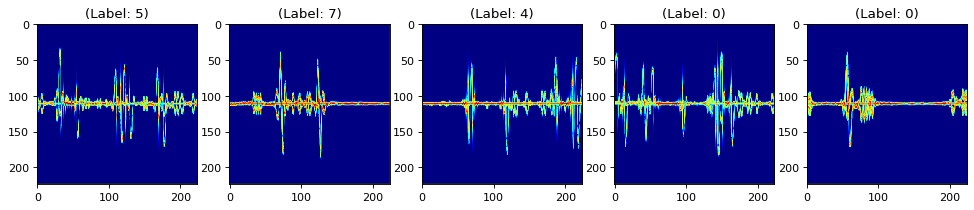

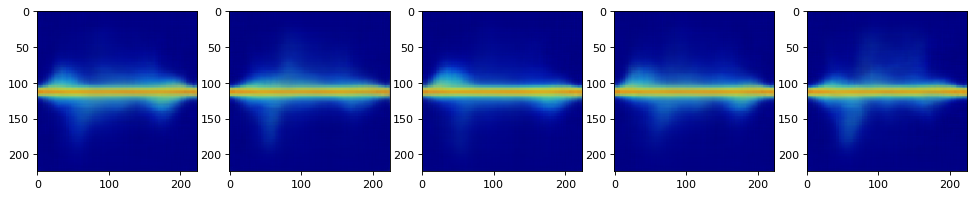

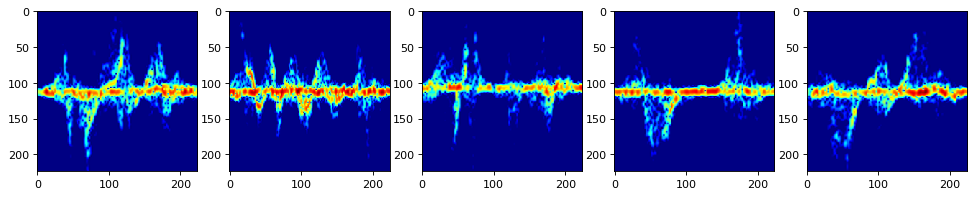

In [68]:
Y_test_label = test_labels
idx = random.randint(0, 300)
plt.figure(figsize=(15, 6), dpi=80)
print("Simulated Spectrograms")
for i in range(5):
    plt.subplot(2, 5, i+1)
#     plt.imshow(test_images2[i, ..., 1]) # , cmap='gray'=0, colored =1
    plt.imshow(test_images2[idx+i]) # , cmap='gray'=0, colored =1
#     plt.imshow(test_images2[idx+i, ..., 1]) # , cmap='gray'=0, colored =1
#     cv2.imshow('color image', test_images2[i]) # , cmap='gray'=0, colored =1
#     img = im.fromarray(test_images2[idx+i].astype(np.uint8)*255)
#     img = test_images2[i].astype(np.uint8)*255
#     plt.imshow(img) # , cmap='gray'=0, colored =1
    curr_lbl = Y_test_label[idx+i]
    plt.title("(Label: " + str(Y_test_label[curr_lbl]) + ")")
# img.save('test.png')
plt.show()    
plt.figure(figsize=(15, 6), dpi=80)
# print("Realism of Test Spectrograms")
for i in range(5):
    plt.subplot(2, 5, i+1)
#     plt.imshow(pred[idx+i, ..., 1]) # , cmap='gray'  
    plt.imshow(pred[idx+i]) # , cmap='gray'  
plt.show()
plt.figure(figsize=(15, 6), dpi=80)
# print("Real Spectrograms")
for i in range(5):
    plt.subplot(2, 5, i+1)
#     plt.imshow(test_images[idx+i, ..., 1]) # , cmap='gray' 
    plt.imshow(test_images[idx+i]) # , cmap='gray'  
plt.show()

# VGG-16 AE

In [58]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

In [61]:
def vgg16_model(img_rows, img_cols, channel=3):
    model = Sequential()
    # Encoder
    model.add(ZeroPadding2D((1, 1), input_shape=(img_rows, img_cols, channel), name='input'))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Add Fully Connected Layer
    model.add(Flatten(name='flatten'))
    model.add(Dense(4096, activation='relu', name='dense1'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name='dense2'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax', name='softmax'))

    # Loads ImageNet pre-trained data
#     weights_path = 'models/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
#     model.load_weights(weights_path)

    return model


In [62]:
epochs = 200
lr = 0.001
optim = Adam(lr=lr) # decay rate = 5e-06 for xethru

autoencoder = vgg16_model(224, 224, 3)
# autoencoder = Model(input_img, decoderX(encoderX(input_img, 3, 32), 3, 32))
autoencoder.compile(loss='mean_squared_error', optimizer = optim)
    
# autoencoder_train = autoencoder.fit(train_images2, train_images, batch_size=batch_size,epochs=epochs, validation_data = (test_images2, test_images), verbose=1, callbacks = [PlotLossesCallback()])
autoencoder_train = autoencoder.fit(train_images2, train_images, batch_size=batch_size,epochs=epochs, 
                                    validation_data = (test_images2, test_images), verbose=1, callbacks = [early_stop])

best_loss = np.min(autoencoder_train.history['val_loss'])
MODEL_FILE = "../models/realism CAE loss_" + str(round(best_loss, 4))  + ".json" # save path
WEIGHT_FILE ="../models/realism CAE loss_" + str(round(best_loss, 4))  +".h5" # save path

model_json = autoencoder.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
# loss = autoencoder_train.history['val_accuracy'][-1]
autoencoder.save_weights(WEIGHT_FILE)
# print("Saved model & weights for with accuracy of " + str(acc))
print("Saved model & weights ", MODEL_FILE)

Epoch 1/200


ValueError: in user code:

    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1195 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10399 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 1000 and 3 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_1/softmax/Softmax, IteratorGetNext:1)' with input shapes: [?,1000], [?,224,224,3].


# Custom CAEs

In [ ]:
# def encoderX(input_img,depth,num_filter):
#     #encoder
#     #input = 128 x 128 x 3 (wide and thin) 128x128x3
    
#     for i in range(depth):
#         conv01 = Conv2D(num_filter, (3, 3), strides=(1, 1), activation='relu', padding='same')(input_img) # 128x128x8
#         conv02 = Conv2D(num_filter, (9, 9), activation='relu', padding='same')(input_img)
#         out01  = concatenate([conv01,conv02],axis=-1)
#         pool = MaxPooling2D(pool_size=(2, 2))(out01) #14 x 14 x 32, 64x64x8
#         input_img = pool
    
#     return input_img

# def decoderX(pool,depth,num_filter):    
#     #decoder
#     for i in range(depth):
#         conv9 = Conv2D(num_filter, (3, 3), activation='relu', padding='same')(pool) # 16x16x16
#         conv10 = Conv2D(num_filter, (9, 9), activation='relu', padding='same')(pool)
#         out5  = concatenate([conv9,conv10], axis=-1)
#         up   = UpSampling2D((2,2))(out5) # 64x64x16
#         pool = up
    
#     decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(up) # 128 x 128 x 3 / Conv2D(1, (3, 3)
    
#     return decoded

In [ ]:
# depth = 3
# num_filter = 16
# autoencoder = Model(input_img, decoderX(encoderX(input_img,depth,num_filter),depth,num_filter))
# autoencoder.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
# autoencoder.summary()

# Train CAE + CNN Bulk

In [ ]:
# depth = [2, 3, 4]
# num_filter = [8, 16, 32]
# radars = [10,24,77]
# epochs = 100
# batch_size = 32
# acc_hist = []
# lr = 0.001
# optim = Adam(lr=lr)
# im_width = 224
# im_height = 224
# inChannel = 3
# input_img = Input(shape = (im_width, im_height, inChannel)) 
# num_class = 11

# for i in range(len(radars)):
#     radar = radars[i]
#     (X_train, Y_train, X_test, Y_test) = select_data(radar)
#     for d in range(len(depth)):
#         for f in range(len(num_filter)):
            
#             autoencoder = Model(input_img, decoderX(encoderX(input_img,depth[d],num_filter[f]),depth[d],num_filter[f]))
#             autoencoder.compile(loss='mean_squared_error', optimizer = optim, metrics=['accuracy'])

#             autoencoder_train = autoencoder.fit(X_train, X_train, validation_data = (X_test,X_test), batch_size=batch_size,epochs=epochs, verbose=0) 
            
#             model2 = Model(input_img , outputs=autoencoder.layers[4*depth[d]].output)
#             model = Sequential()

#             model.add(model2)
#             model.add(Flatten())
#             model.add(Dense(128, activation='relu'))
#             model.add(Dropout(0.5))

#             model.add(Dense(128, activation='relu'))
#             model.add(Dropout(0.5))

#             model.add(Dense(num_class))
#             model.add(Activation('softmax'))

            
#             model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
#             history = model.fit(X_train, Y_train,
#                             batch_size=batch_size,
#                             epochs=epochs,
#                             verbose=0,
#                             validation_data=(X_test, Y_test)
# #                                     callbacks = [PlotLossesCallback()]
#                                  )
#             acc = history.history['val_accuracy'][-1]
#             acc_hist.append(acc)
                    
#             MODEL_FILE = "../models/realism "+str(depth[d])+"depth "+str(num_filter[f])+"filter "+  str(num_class)+"class CAE.json" # save path
#             WEIGHT_FILE ="../models/realism "+str(depth[d])+"depth "+str(num_filter[f])+"filter "+  str(num_class)+"class CAE.h5" # save path

#             model_json = autoencoder.to_json()
#             with open(MODEL_FILE, "w") as json_file:
#                 json_file.write(model_json)
#             acc = history.history['val_accuracy'][-1]
#             acc_hist.append(acc)
#             autoencoder.save_weights(WEIGHT_FILE)
            
#             print('Parameters for '+str(radar) +' GHz: Depth = '+str(depth[d])+', Num_filter = '+str(num_filter[f])+
#                   ', Accuracy = '+str(acc))